Bonhoure Timothé et Martinez Christophe

# GNN : Projet

In [1]:
#import

import torch
from torch_geometric.utils import from_networkx, train_test_split_edges
from torch_geometric.nn import VGAE
import networkx as nx
from sklearn.preprocessing import LabelEncoder

from GCN import GCN, SimpleGCN
from encoder import Encoder
from decoder import Decoder

from sklearn.metrics import confusion_matrix
import seaborn as sns

import pandas as pd
from matplotlib import pyplot as plt
import time

In [2]:
# Load the network
G = nx.read_graphml("data/airportsAndCoordAndPop.graphml")

[]

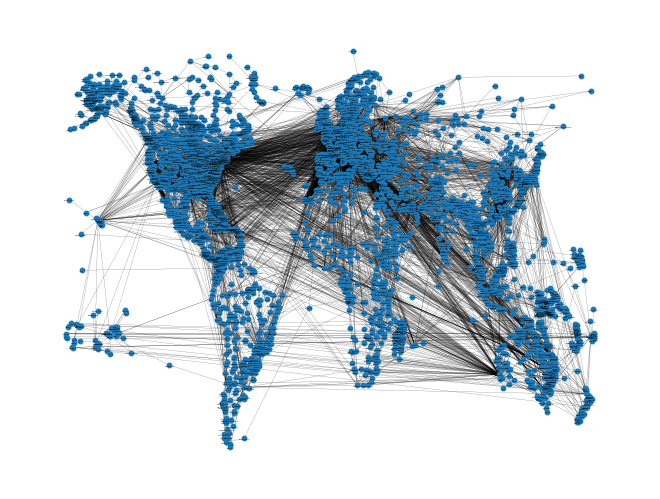

In [3]:
node_positions = {node: (data['lon'], data['lat']) for node, data in G.nodes(data=True)}
labels = {node: (data['city_name']) for node, data in G.nodes(data=True)}
nx.draw_networkx_edges
nx.draw(G, pos=node_positions, with_labels=True, labels=labels, font_size=1, node_size=10, width = 0.1)
plt.plot()

In [4]:
G.graph = {} 
data = from_networkx(G, group_node_attrs=["lon","lat"])

print(data)
print(data.num_features)
print(len(set(data.country)))

Data(edge_index=[2, 27094], population=[3363], country=[3363], city_name=[3363], x=[3363, 2])
2
212


In [5]:
encoder = LabelEncoder()
integer_labels = encoder.fit_transform(data.country)
target_tensor = torch.tensor(integer_labels, dtype=torch.long)
data.y = target_tensor
data.num_classes = len(set(data.country))

In [6]:
num_nodes = data.num_nodes
train_ratio = 0.80 # 80% of nodes for training
# Randomly creating a mask
mask = torch.rand(num_nodes) < train_ratio
data.train_mask = mask
data.test_mask = data.train_mask
# remove the attributes for the nodes that are not in the training set
temp = torch.zeros((num_nodes, 2), dtype=torch.float)
temp[data.train_mask] = data.x[data.train_mask]
data.x = temp

In [7]:
print(data.x)

tensor([[-145.5097,  -17.3539],
        [-140.9500,  -18.0667],
        [-149.6000,  -17.5500],
        ...,
        [-113.2039,   54.7431],
        [ 146.6000,   -6.1333],
        [ 147.2500,   -6.0000]])


In [8]:
model = GCN(dim_in=data.num_features, dim_h=100, dim_out=data.num_classes)
model.fit(data, 100)

In [9]:
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.5560


In [10]:
G.graph = {} 
encoder = LabelEncoder()
encoder.fit([G.nodes[node]["country"] for node in G.nodes])

for node in G.nodes :
    G.nodes[node]["country_code"] = encoder.transform([G.nodes[node]["country"]])[0]


data = from_networkx(G, group_node_attrs=["lon","lat","country_code"])

print(data)
print(data.num_features)

Data(edge_index=[2, 27094], population=[3363], country=[3363], city_name=[3363], x=[3363, 3])
3


In [11]:
dt = data.__copy__()
train_test_split_edges(dt)
print(dt)
dt.num_classes = len(set(data.country))

/home/stouf/anaconda3/envs/BIML/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(population=[3363], country=[3363], city_name=[3363], x=[3363, 3], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354])


In [12]:
def fit(model, data, epochs, verbose=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    for epoch in range(epochs+1):
        if epoch % 100 == 0 and verbose :
            z = vgae.encode(dt.x, dt.train_pos_edge_index)
            print(epoch, " : ", vgae.test(z, dt.test_pos_edge_index, dt.test_neg_edge_index))
        optimizer.zero_grad()
        z = model.encode(dt.x, dt.train_pos_edge_index)
        loss = model.recon_loss(z, data.train_pos_edge_index) + (1 / dt.num_nodes) * model.kl_loss()
        loss.backward()
        optimizer.step()

In [15]:
encoder = Encoder(in_channels=dt.num_features, out_channels=15, dropout=0.3)
decoder = Decoder(15)

vgae = VGAE(encoder, decoder)

fit(vgae, dt, 2000)

z = vgae.encode(dt.x, dt.train_pos_edge_index)
AUC, PA = vgae.test(z, dt.test_pos_edge_index, dt.test_neg_edge_index)

ValueError: Found input variables with inconsistent numbers of samples: [2708, 6726]

In [26]:
def test_dropout(file_path, dropouts, epochs):
    dt = data.__copy__()
    train_test_split_edges(dt)
    print(dt)
    dt.num_classes = len(set(data.country))
    
    with open(file_path, "w") as f:
        f.write("Dropout;AUC;AP;epochs;elapsed_time\n")

    for dropout in dropouts:
        print("Dropout : ", dropout)
        
        encoder = Encoder(in_channels=dt.num_features, out_channels=15, dropout=dropout)
        vgae = VGAE(encoder)
        
        start_time = time.time()
        fit(vgae, dt, epochs, verbose=False)
        elapsed_time = time.time() - start_time

        z = vgae.encode(dt.x, dt.train_pos_edge_index)
        AUC, AP = vgae.test(z, dt.test_pos_edge_index, dt.test_neg_edge_index)
        
        with open(file_path, "a") as f:
            f.write(f"{dropout};{AUC};{AP};{epochs};{elapsed_time}\n")
        print(f"{dropout};{AUC};{AP};{epochs};{elapsed_time}")

In [27]:
test_dropout("test_dropout.txt", [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7], 1000)

/home/stouf/anaconda3/envs/BIML/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(population=[3363], country=[3363], city_name=[3363], x=[3363, 3], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354])
Dropout :  0
0;0.9167325763807221;0.8999604533182092;1000;77.28975033760071
Dropout :  0.1
0.1;0.8943218190426527;0.8489747117780955;1000;76.90594291687012
Dropout :  0.2
0.2;0.9070610303951964;0.89944070452616;1000;75.7829942703247
Dropout :  0.3
0.3;0.918517047797543;0.9201434028186868;1000;70.02948832511902
Dropout :  0.4
0.4;0.851042318945561;0.8282099897190986;1000;76.87759900093079
Dropout :  0.5
0.5;0.9031481752191111;0.8989520603426574;1000;76.36493349075317
Dropout :  0.6
0.6;0.8292512038295635;0.7948662157430436;1000;76.14054918289185
Dropout :  0.7
0.7;0.864437718320246;0.8528559509160543;1000;72.39120149612427


- chercher sur differentes couches 
- tester dropout
- tester entrainer decodeur